<a href="https://colab.research.google.com/github/praths007/predicting_reddit_post_engagement/blob/main/Predicting_reddit_post_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AML Group Project - MSBA Fall'22
## Reddit engagement prediction
---

**Group 9 - Ankit Muthiyan, Rochan Nehete, Amanda Nguyen, Prathmesh Savale, Rishabh Tiwari**

In [ ]:
# %%shell
# jupyter nbconvert --to html /content/AML_project_predict_reddit_engagement.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Scrapping Data From Reddit

## Using praw to scrape posts

In [ ]:
!pip install praw
!pip install psaw
!pip install regressors
!pip install shap
!pip install bayesian-optimization
!pip install keybert
!pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 4.7 MB/s 
     |████████████████████████████████| 55 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12400 sha256=dd2bca53c6b29d118c8f24e9720a9ec67285284ec617e2a44be026872ec6dced
  Stored in directory: /root/.cache/pip/wheels/46/c3/e9/d1797db3a01a1f101ad3cbcdf01b1be7273a25c78c77dd4bb9
Successfully built regressors
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org

In [ ]:
# importing required libraries
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pprint import pprint
import numpy as np
import praw
import pdb
import operator
import warnings
import shap
from keybert import KeyBERT
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, plot_roc_curve
import xgboost as xgb
from bayes_opt import BayesianOptimization
xgb.__version__


warnings.filterwarnings("ignore")

In [ ]:
# to deal with dates - conversion to central time
from datetime import datetime, timezone
import pytz

fmt = '%Y-%m-%d %H:%M:%S %Z%z'
e = pytz.timezone('US/Central')

In [ ]:
# https://praw.readthedocs.io/en/stable/ (credentials have been removed for priviacy - refer to this for setting up new credentials - https://towardsdatascience.com/scraping-reddit-data-1c0af3040768)
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    password="",
    user_agent="",
    username="",check_for_async=False
)
print(reddit.user.me())

diamond_hands_007


In [ ]:
# checking data frm reddit
subReddit = reddit.subreddit('all')
df = pd.DataFrame([ vars(post) for post in subReddit.top("month", limit=2) ])
df

,comment_limit,comment_sort,_reddit,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,_fetched,_comments_by_id,link_flair_template_id
0,2048,confidence,<praw.reddit.Reddit object at 0x7f0aa9346640>,None,nextfuckinglevel,,t2_2bcyd83q,False,None,3,...,False,https://v.redd.it/qh2uhpfxe44a1,7299998,1.670264e+09,23,"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,False,{},NaN
1,2048,confidence,<praw.reddit.Reddit object at 0x7f0aa9346640>,None,MadeMeSmile,,t2_t3phj9d2,False,None,6,...,False,https://i.imgur.com/IJc8s88.jpg,6896741,1.669581e+09,15,None,False,False,{},b84cc580-cd46-11ea-b23c-0ef1a184f463


In [ ]:
!pip list | grep praw

praw                          7.6.1
prawcore                      2.3.0


In [ ]:
# # Retrieve the top (most upvoted) 1k posts in the last year and add them to a Pandas dataframe
# top_posts = []
# subReddit = reddit.subreddit('all')
# for post in tqdm(subReddit.top("day",limit=1000), total=1000):
#     top_posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, \
#                   post.spoiler, post.upvote_ratio, post.top_awarded_type, post.num_crossposts, post.subreddit_subscribers, post.locked, post.edited, post.is_original_content, post.view_count, \
#                   post.num_reports, post.removed_by_category]) 
# top_posts = pd.DataFrame(top_posts, columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', \
#                                   'is_self', 'over_18', 'spoiler', 'upvote_ratio', 'top_awarded_type', 'num_crossposts', 'subreddit_subscribers',\
#                                    'locked', 'edited', 'is_original_content', 'view_count', 'num_reports', 'removed_by_category'])
# top_posts.to_csv("/content/drive/MyDrive/AML_project/top_posts_day.csv", index=False)

# # Retrieve the most controversial (most downvoted) 1k posts in the last year and add them to a Pandas dataframe
# controversial_posts = []
# subReddit = reddit.subreddit('all')
# for post in tqdm(subReddit.controversial("day",limit=1000), total=1000):
#     controversial_posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, \
#                   post.spoiler, post.upvote_ratio, post.top_awarded_type, post.num_crossposts, post.subreddit_subscribers, post.locked, post.edited, post.is_original_content, post.view_count, \
#                   post.num_reports, post.removed_by_category]) 
# controversial_posts = pd.DataFrame(controversial_posts, columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', \
#                                   'is_self', 'over_18', 'spoiler', 'upvote_ratio', 'top_awarded_type', 'num_crossposts', 'subreddit_subscribers',\
#                                    'locked', 'edited', 'is_original_content', 'view_count', 'num_reports', 'removed_by_category'])
# controversial_posts.to_csv("/content/drive/MyDrive/AML_project/controversial_posts_day.csv", index=False)

In [ ]:
top_posts_day = pd.read_csv("/content/drive/MyDrive/AML_project/top_posts_day.csv")
top_posts_hour = pd.read_csv("/content/drive/MyDrive/AML_project/top_posts_hour.csv")
top_posts_month = pd.read_csv("/content/drive/MyDrive/AML_project/top_posts_month.csv")
top_posts_week = pd.read_csv("/content/drive/MyDrive/AML_project/top_posts_week.csv")
top_posts_all = pd.read_csv("/content/drive/MyDrive/AML_project/top_posts_all.csv")

controversial_posts_day = pd.read_csv("/content/drive/MyDrive/AML_project/controversial_posts_day.csv")
controversial_posts_hour = pd.read_csv("/content/drive/MyDrive/AML_project/controversial_posts_hour.csv")
controversial_posts_month = pd.read_csv("/content/drive/MyDrive/AML_project/controversial_posts_month.csv")
controversial_posts_week = pd.read_csv("/content/drive/MyDrive/AML_project/controversial_posts_week.csv")
controversial_posts_all = pd.read_csv("/content/drive/MyDrive/AML_project/controversial_posts_all.csv")

In [ ]:
top_posts = pd.concat([top_posts_day, top_posts_hour, top_posts_month, top_posts_week, top_posts_all])
controversial_posts = pd.concat([controversial_posts_day, controversial_posts_hour, controversial_posts_month, controversial_posts_week, controversial_posts_all])

In [ ]:
#Top 10 List of subreddits that have broken top 1k
top_subs = top_posts.subreddit.unique() 
top_subs[:10]

array(['nextfuckinglevel', 'meirl', 'Unexpected', 'aww', 'space',
       'ProgrammerHumor', 'mildlyinfuriating', 'memes',
       'interestingasfuck', 'WhitePeopleTwitter'], dtype=object)

In [ ]:
 #Top 10 subreddits that have broken most controversial 1k
controversialSubReddits = controversial_posts.subreddit.unique()
controversialSubReddits[0:10]

array(['Conservative', 'pics', 'WhitePeopleTwitter', 'CombatFootage',
       'assholedesign', 'ich_iel', 'pathofexile', 'fightporn',
       'LivestreamFail', 'Miami'], dtype=object)

## Dataset Creation

In [ ]:
# assigning 1 to top post and 0 to controversial
top_posts["post_type"] = 1
controversial_posts["post_type"] = 0
posts_df = pd.concat([top_posts, controversial_posts])

# Feature Engineering

In [ ]:
# word counts for text
posts_df['title_word_count'] = posts_df['title'].apply(lambda x: str(x).split()).apply(lambda x:len(x))
posts_df['body_word_count'] = posts_df['body'].apply(lambda x: str(x).split()).apply(lambda x:len(x))

In [ ]:
# converting utc to cst
posts_df['created_cst'] = posts_df['created'].apply(lambda x: datetime.fromtimestamp(x, tz=timezone.utc)).apply(lambda x: x.astimezone(tz=pytz.timezone('US/Central')))
posts_df['edited_cst'] = posts_df['edited'].apply(lambda x: None if x=='False' else datetime.fromtimestamp(int(float(x)), tz=timezone.utc).astimezone(tz=pytz.timezone('US/Central')))

In [ ]:
# diff between created and edited time
posts_df['create_edit_days'] = (posts_df['edited_cst'] - posts_df['created_cst']).dt.days

In [ ]:
# converting time date created to time of year, month, date, (time of day - morning, evening, night etc.)
posts_df['created_month'] = posts_df['created_cst'].dt.month
posts_df['created_day'] = posts_df['created_cst'].dt.day
posts_df = posts_df.assign(created_session=pd.cut(posts_df['created_cst'].dt.hour, [0,6,12,18,23], labels=['Night','Morning','Afternoon','Evening'], include_lowest=True))

In [ ]:
# checking for column data types
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8301 entries, 0 to 680
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype                     
---  ------                 --------------  -----                     
 0   title                  8301 non-null   object                    
 1   score                  8301 non-null   int64                     
 2   id                     8301 non-null   object                    
 3   subreddit              8301 non-null   object                    
 4   url                    8301 non-null   object                    
 5   num_comments           8301 non-null   int64                     
 6   body                   1518 non-null   object                    
 7   created                8301 non-null   float64                   
 8   author                 8205 non-null   object                    
 9   is_self                8301 non-null   bool                      
 10  over_18                8301 non-null 

In [ ]:
# removing unwanted columns
cols_to_drop = ['id', 'url', 'author', 'created', 'top_awarded_type', 'edited', 'created_cst', 'edited_cst']
posts_df = posts_df.drop(columns = cols_to_drop).copy()
posts_df.head(4)

,title,score,subreddit,num_comments,body,is_self,over_18,spoiler,upvote_ratio,num_crossposts,...,view_count,num_reports,removed_by_category,post_type,title_word_count,body_word_count,create_edit_days,created_month,created_day,created_session
0,"Citizens chant ""CCP, step down"" and ""Xi Jinpin...",124406,nextfuckinglevel,6070,NaN,False,False,False,0.87,53,...,NaN,NaN,NaN,1,16,1,NaN,11,26,Afternoon
1,Meirl,100724,meirl,827,NaN,False,False,False,0.93,3,...,NaN,NaN,NaN,1,1,1,NaN,11,26,Afternoon
2,Mime pranking a tourist!,84583,Unexpected,653,NaN,False,False,False,0.92,18,...,NaN,NaN,NaN,1,4,1,NaN,11,26,Evening
3,"My wife, my daughter, and my grandson, sitting...",82613,aww,1035,NaN,False,False,False,0.90,4,...,NaN,NaN,NaN,1,14,1,NaN,11,26,Afternoon


# Exploratory Data Analysis

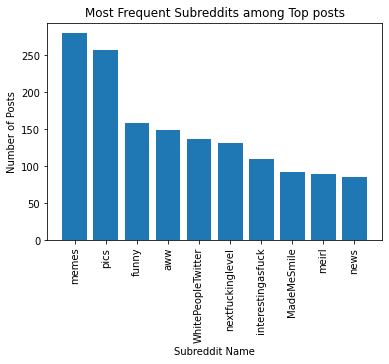

In [ ]:
top = posts_df[posts_df['post_type'] == 1]
subs = top.groupby(['subreddit']).size().reset_index(name='count').sort_values(by = 'count', ascending = False)
subs
# top_subs = subs[subs['count'] > 20]
top_subs = subs.head(10)

plt.bar(top_subs['subreddit'], top_subs['count'], align='center')
# plt.plot(top_subs['subreddit'], top_subs['subreddit_subscribers'])
plt.xticks(rotation='vertical')
plt.title("Most Frequent Subreddits among Top posts")
plt.ylabel("Number of Posts")
plt.xlabel("Subreddit Name")
plt.show()

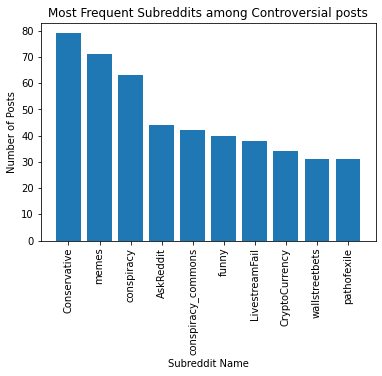

In [ ]:
contro = posts_df[posts_df['post_type'] == 0]
subs = contro.groupby(['subreddit']).size().reset_index(name='count').sort_values(by = 'count', ascending = False)
subs
# contro_subs = subs[subs['count'] > 10]
contro_subs = subs.head(10)

plt.bar(contro_subs['subreddit'], contro_subs['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("Most Frequent Subreddits among Controversial posts")
plt.ylabel("Number of Posts")
plt.xlabel("Subreddit Name")
plt.show()

### Conservative, conspiracy....

10.15469483568075
8.0


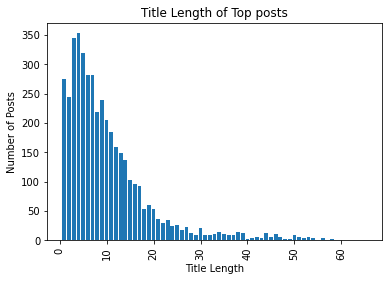

In [ ]:
top = posts_df[posts_df['post_type'] == 1]
print(top['title_word_count'].mean())
print(top['title_word_count'].median())

top = top.groupby(['title_word_count']).size().reset_index(name='count')

contro = posts_df[posts_df['post_type'] == 0]
contro = contro.groupby(['title_word_count']).size().reset_index(name='count')
contro

plt.bar(top['title_word_count'], top['count'])
plt.xticks(rotation='vertical')
plt.title("Title Length of Top posts")
plt.ylabel("Number of Posts")
plt.xlabel("Title Length")
plt.show()

Text(0.5, 1.0, 'Title word count of posts by Controversial/Top posts')

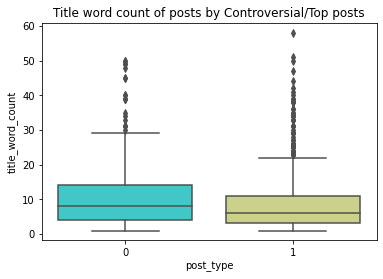

In [ ]:
consistent_subs = top_subs.head(5).append(contro_subs.head(5), ignore_index=True)
consistent_subs_posts_df = posts_df.merge(consistent_subs,how='inner',left_on=['subreddit'],right_on=['subreddit'])
sns.boxplot(x='post_type',y='title_word_count',data=consistent_subs_posts_df,palette='rainbow')
plt.title("Title word count of posts by Controversial/Top posts")

Text(0.5, 1.0, 'Title word count of Top posts by subreddit')

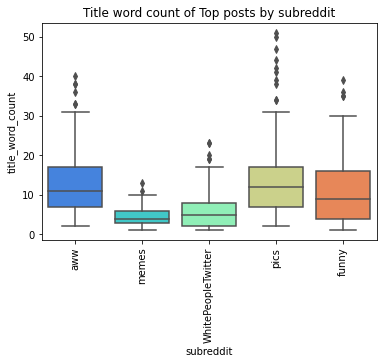

In [ ]:
top_subs_posts_df = posts_df.merge(top_subs.head(5),how='inner',left_on=['subreddit'],right_on=['subreddit'])
top_subs_posts_df = top_subs_posts_df[top_subs_posts_df['post_type'] == 1]
sns.boxplot(x='subreddit',y='title_word_count',data=top_subs_posts_df,palette='rainbow')
plt.xticks(rotation='vertical')
plt.title("Title word count of Top posts by subreddit")

Text(0.5, 1.0, 'Title word count of Controversial posts by subreddit')

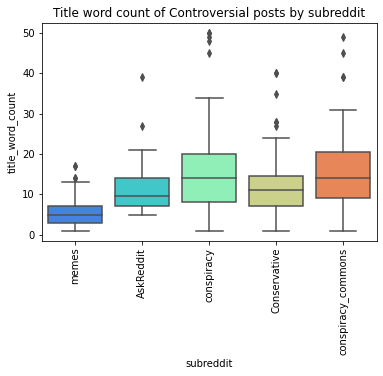

In [ ]:
contro_subs_posts_df = posts_df.merge(contro_subs.head(5),how='inner',left_on=['subreddit'],right_on=['subreddit'])
contro_subs_posts_df = contro_subs_posts_df[contro_subs_posts_df['post_type'] == 0]
sns.boxplot(x='subreddit',y='title_word_count',data=contro_subs_posts_df,palette='rainbow')
plt.xticks(rotation='vertical')
plt.title("Title word count of Controversial posts by subreddit")

10.495669388765156
8.0


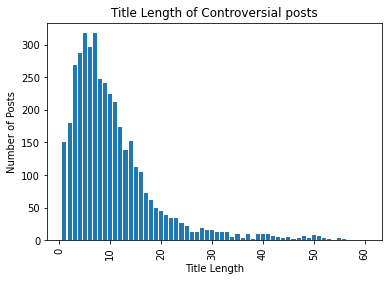

In [ ]:
from numpy.core.fromnumeric import mean
from numpy.lib.function_base import average
contro = posts_df[posts_df['post_type'] == 0]
print(average(contro['title_word_count']))
print(contro['title_word_count'].median())

subs = contro.groupby(['title_word_count']).size().reset_index(name='count')

plt.bar(subs['title_word_count'], subs['count'])
plt.xticks(rotation='vertical')
plt.title("Title Length of Controversial posts")
plt.ylabel("Number of Posts")
plt.xlabel("Title Length")
plt.show()

### Avg title length is slightly more for controversial posts

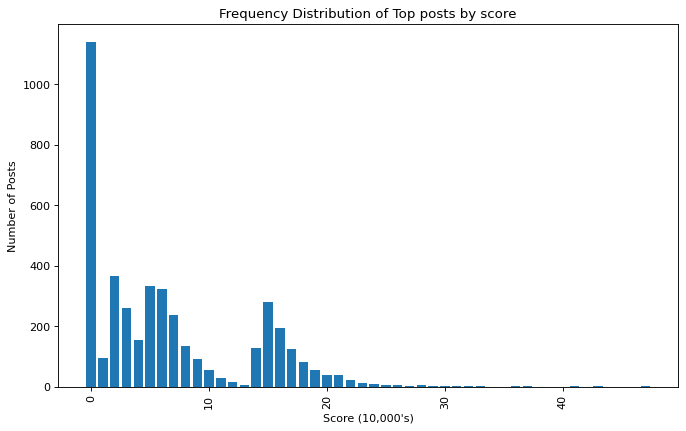

In [ ]:
from matplotlib.pyplot import figure

top = posts_df[posts_df['post_type'] == 1]

top['score'] = (top['score']/10000)
top = top.astype({"score": int})

freq = top.groupby(['score']).size().reset_index(name='count')

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['score'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("Frequency Distribution of Top posts by score")
plt.ylabel("Number of Posts")
plt.xlabel("Score (10,000's)")
plt.show()

Text(0.5, 1.0, 'Score of posts by Controversial/Top')

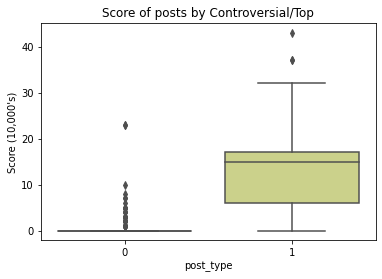

In [ ]:
consistent_subs_posts_df = posts_df.merge(consistent_subs,how='inner',left_on=['subreddit'],right_on=['subreddit'])

consistent_subs_posts_df['score'] = (consistent_subs_posts_df['score']/10000)
consistent_subs_posts_df = consistent_subs_posts_df.astype({"score": int})

sns.boxplot(x='post_type',y='score',data=consistent_subs_posts_df,palette='rainbow').set(ylabel="Score (10,000's)")
plt.title("Score of posts by Controversial/Top")

Text(0.5, 1.0, 'Score of Top posts by subreddit')

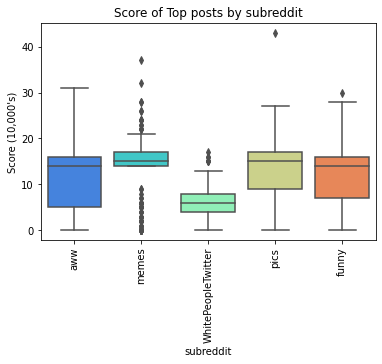

In [ ]:
top_subs_posts_df = posts_df.merge(top_subs.head(5),how='inner',left_on=['subreddit'],right_on=['subreddit'])
top_subs_posts_df = top_subs_posts_df[top_subs_posts_df['post_type'] == 1]

top_subs_posts_df['score'] = (top_subs_posts_df['score']/10000)
top_subs_posts_df = top_subs_posts_df.astype({"score": int})

sns.boxplot(x='subreddit',y='score',data=top_subs_posts_df,palette='rainbow').set(ylabel="Score (10,000's)")
plt.xticks(rotation='vertical')
plt.title("Score of Top posts by subreddit")

Text(0.5, 1.0, 'Score of Controversial posts by subreddit')

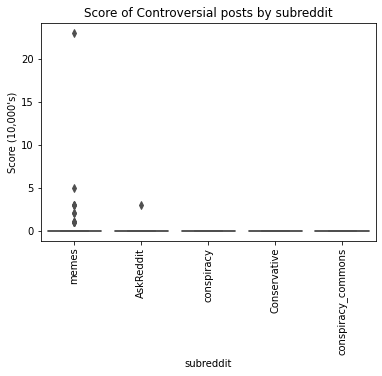

In [ ]:
contro_subs_posts_df = posts_df.merge(contro_subs.head(5),how='inner',left_on=['subreddit'],right_on=['subreddit'])
contro_subs_posts_df = contro_subs_posts_df[contro_subs_posts_df['post_type'] == 0]

contro_subs_posts_df['score'] = (contro_subs_posts_df['score']/10000)
contro_subs_posts_df = contro_subs_posts_df.astype({"score": int})

sns.boxplot(x='subreddit',y='score',data=contro_subs_posts_df,palette='rainbow').set(ylabel="Score (10,000's)")
plt.xticks(rotation='vertical')
plt.title("Score of Controversial posts by subreddit")

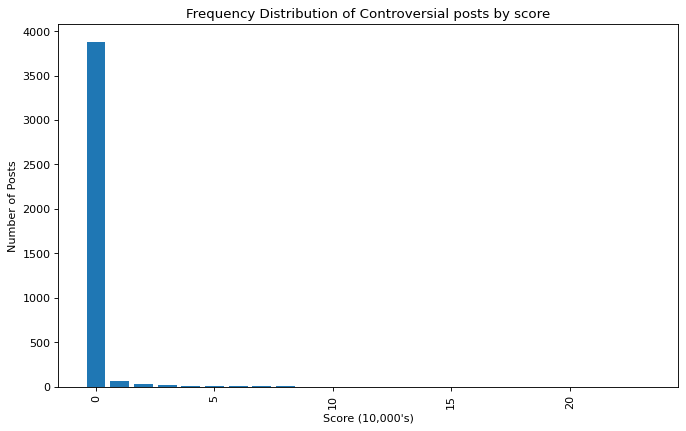

In [ ]:
contro = posts_df[posts_df['post_type'] == 0]

contro['score'] = (contro['score']/10000)
contro = contro.astype({"score": int})

freq = contro.groupby(['score']).size().reset_index(name='count')
# freq = freq[freq['score']>1]

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['score'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("Frequency Distribution of Controversial posts by score")
plt.ylabel("Number of Posts")
plt.xlabel("Score (10,000's)")
plt.show()

1907.4732394366197
949.5


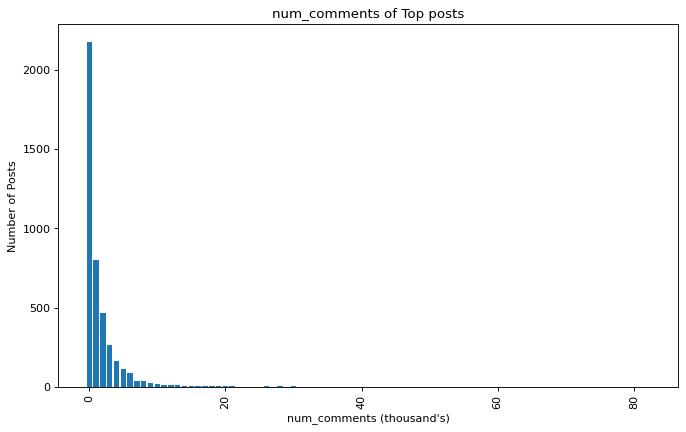

In [ ]:
top = posts_df[posts_df['post_type'] == 1]
print(average(top['num_comments']))
print(top['num_comments'].median())

top['num_comments'] = (top['num_comments']/1000)
top = top.astype({"num_comments": int})

freq = top.groupby(['num_comments']).size().reset_index(name='count')

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['num_comments'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("num_comments of Top posts")
plt.ylabel("Number of Posts")
plt.xlabel("num_comments (thousand's)")
plt.show()

181.07770353872803
37.0


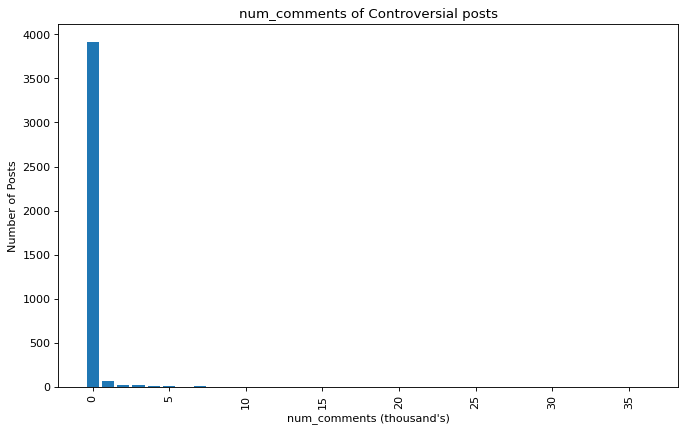

In [ ]:
contro = posts_df[posts_df['post_type'] == 0]
print(average(contro['num_comments']))
print(contro['num_comments'].median())

contro['num_comments'] = (contro['num_comments']/1000)
contro = contro.astype({"num_comments": int})

freq = contro.groupby(['num_comments']).size().reset_index(name='count')
# freq = freq[freq['num_comments']>1]

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['num_comments'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("num_comments of Controversial posts")
plt.ylabel("Number of Posts")
plt.xlabel("num_comments (thousand's)")
plt.show()

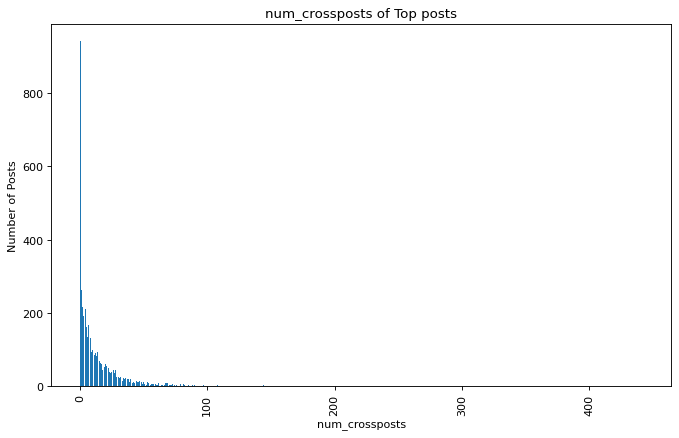

In [ ]:
top = posts_df[posts_df['post_type'] == 1]

freq = top.groupby(['num_crossposts']).size().reset_index(name='count')#.sort_values(by = 'count', ascending = False)
# freq = freq[freq['count']>=3]

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['num_crossposts'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("num_crossposts of Top posts")
plt.ylabel("Number of Posts")
plt.xlabel("num_crossposts")
plt.show()

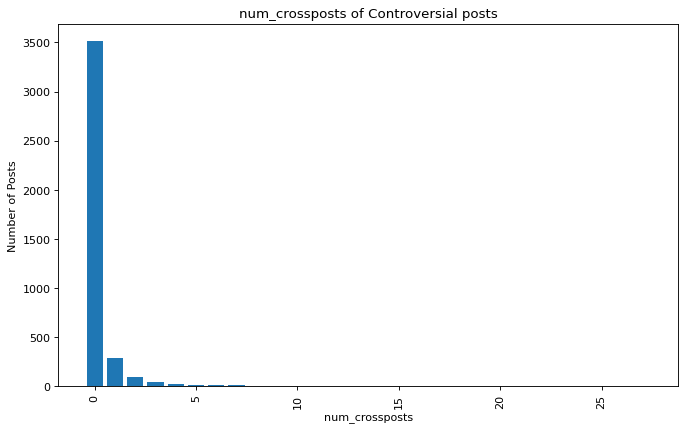

In [ ]:
contro = posts_df[posts_df['post_type'] == 0]

freq = contro.groupby(['num_crossposts']).size().reset_index(name='count')#.sort_values(by = 'count', ascending = False)
freq = freq[freq['count']>=2]

figure(figsize=(10,6), dpi = 80)
plt.bar(freq['num_crossposts'], freq['count'], align='center')
plt.xticks(rotation='vertical')
plt.title("num_crossposts of Controversial posts")
plt.ylabel("Number of Posts")
plt.xlabel("num_crossposts")
plt.show()

Text(0.5, 1.0, 'Upvote Ratio over time of day')

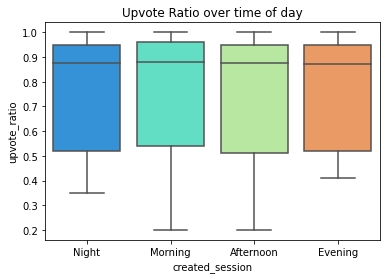

In [ ]:
# posting in the morning shows slightly better impact
sns.boxplot(x='created_session',y='upvote_ratio',data=posts_df,palette='rainbow')
sns.set(rc={'figure.figsize':(15,10)})
plt.title("Upvote Ratio over time of day")

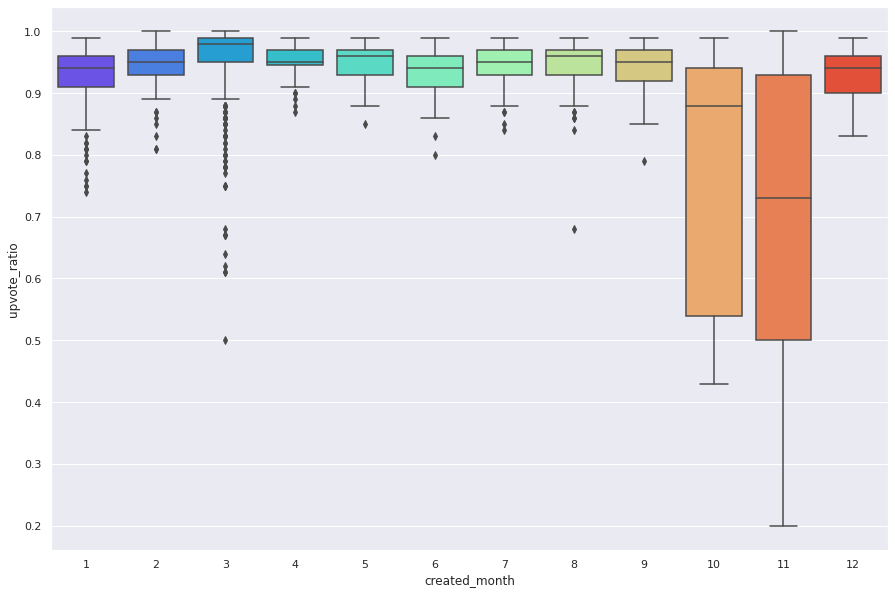

In [ ]:
# posting in month of october and november shows less engagement
sns.boxplot(x='created_month',y='upvote_ratio',data=posts_df,palette='rainbow')

sns.set(rc={'figure.figsize':(15,10)})

# Data Preprocessing

In [ ]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8301 entries, 0 to 680
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   title                  8301 non-null   object  
 1   score                  8301 non-null   int64   
 2   subreddit              8301 non-null   object  
 3   num_comments           8301 non-null   int64   
 4   body                   1518 non-null   object  
 5   is_self                8301 non-null   bool    
 6   over_18                8301 non-null   bool    
 7   spoiler                8301 non-null   bool    
 8   upvote_ratio           8301 non-null   float64 
 9   num_crossposts         8301 non-null   int64   
 10  subreddit_subscribers  8301 non-null   int64   
 11  locked                 8301 non-null   bool    
 12  is_original_content    8301 non-null   bool    
 13  view_count             0 non-null      float64 
 14  num_reports            0 non-null      fl

In [ ]:
# converting bool and yes and no values to 1 and 0
preprocess_encode = LabelEncoder()
posts_df['is_self'] = preprocess_encode.fit_transform(posts_df['is_self'])
posts_df['over_18'] = preprocess_encode.fit_transform(posts_df['over_18'])
posts_df['spoiler'] = preprocess_encode.fit_transform(posts_df['spoiler'])
posts_df['locked'] = preprocess_encode.fit_transform(posts_df['locked'])
posts_df['is_original_content'] = preprocess_encode.fit_transform(posts_df['is_original_content'])

In [ ]:
# creating dummies
session_dummies = pd.get_dummies(posts_df['created_session'], drop_first=True)
rm_category_dummies = pd.get_dummies(posts_df['removed_by_category'], drop_first=True)
month_dummies = pd.get_dummies(posts_df['created_month'], prefix='month', prefix_sep='_', drop_first=True)
day_dummies = pd.get_dummies(posts_df['created_day'], prefix='day', prefix_sep='_', drop_first=True)

In [ ]:
# concating the dummy columns
posts_df = pd.concat([posts_df, session_dummies], axis=1)
posts_df = pd.concat([posts_df, rm_category_dummies], axis=1)
posts_df = pd.concat([posts_df, day_dummies], axis=1)
posts_df = pd.concat([posts_df, month_dummies], axis=1)
posts_df.head(5)

,title,score,subreddit,num_comments,body,is_self,over_18,spoiler,upvote_ratio,num_crossposts,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"Citizens chant ""CCP, step down"" and ""Xi Jinpin...",124406,nextfuckinglevel,6070,NaN,0,0,0,0.87,53,...,0,0,0,0,0,0,0,0,1,0
1,Meirl,100724,meirl,827,NaN,0,0,0,0.93,3,...,0,0,0,0,0,0,0,0,1,0
2,Mime pranking a tourist!,84583,Unexpected,653,NaN,0,0,0,0.92,18,...,0,0,0,0,0,0,0,0,1,0
3,"My wife, my daughter, and my grandson, sitting...",82613,aww,1035,NaN,0,0,0,0.90,4,...,0,0,0,0,0,0,0,0,1,0
4,My best astrophotography image since starting ...,70435,space,520,NaN,0,0,0,0.94,10,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# replace all nulls with 0
posts_df['view_count'].fillna(0, inplace=True)
posts_df['num_reports'].fillna(0, inplace=True)
posts_df['removed_by_category'].fillna(0, inplace=True)
posts_df['create_edit_days'].fillna(0, inplace=True)


In [ ]:
cols_to_drop = ['view_count', 'num_reports', 'created_session', 'subreddit', 'removed_by_category', 'upvote_ratio', 'score', 'num_comments', 'num_crossposts', 'created_month', 'locked', 'subreddit_subscribers', 'created_day']
posts_df = posts_df.drop(columns = cols_to_drop)
posts_df.head(4)

,title,body,is_self,over_18,spoiler,is_original_content,post_type,title_word_count,body_word_count,create_edit_days,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"Citizens chant ""CCP, step down"" and ""Xi Jinpin...",NaN,0,0,0,0,1,16,1,0.0,...,0,0,0,0,0,0,0,0,1,0
1,Meirl,NaN,0,0,0,0,1,1,1,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Mime pranking a tourist!,NaN,0,0,0,0,1,4,1,0.0,...,0,0,0,0,0,0,0,0,1,0
3,"My wife, my daughter, and my grandson, sitting...",NaN,0,0,0,0,1,14,1,0.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# removing filling nans with 0's (this only happends for create edits days column)
posts_df = posts_df.fillna(0)

# Model Building

In [ ]:
# there is not a lot of between subreddits of top and controversial posts
1 - len(set(list(top_subs.keys())).intersection(list(cont_subs.keys()))) / len(set(list(top_subs.keys()) + list(cont_subs.keys())))

0.8276923076923077

In [ ]:
# removing post type (depedent variable from X)
posts_df_bk = posts_df.copy()
y = posts_df['post_type']
del posts_df['post_type']
X = posts_df

In [ ]:
# creating a stratified split
X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=0.3, random_state=15)

In [ ]:
X_train_bk = X_train.copy()
X_test_bk = X_test.copy()

In [ ]:
# removing features with text
del X_train['body']
del X_train['title']
del X_test['body']
del X_test['title']

In [ ]:
# scaling features so everything is uniform
scaler = StandardScaler()
Xscaled_fit = scaler.fit(X_train)
Xscaled_train = Xscaled_fit.transform(X_train)
Xscaled_test= Xscaled_fit.transform(X_test)

In [ ]:
# fitting logistic regression (without subreddit name feature)
clf_wo_subreddit = LogisticRegressionCV(cv=5, random_state=0).fit(Xscaled_train, y_train)
preds = clf_wo_subreddit.predict(Xscaled_test)
pred_prob = clf_wo_subreddit.predict_proba(Xscaled_test)



              precision    recall  f1-score   support

           0       0.90      0.48      0.63      1213
           1       0.66      0.95      0.78      1278

    accuracy                           0.72      2491
   macro avg       0.78      0.72      0.70      2491
weighted avg       0.78      0.72      0.71      2491





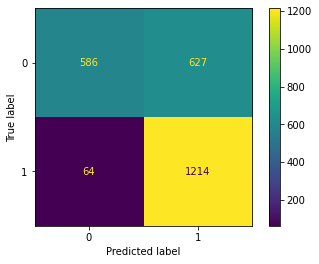

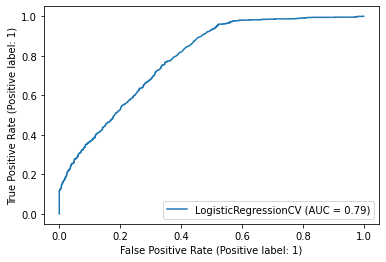

In [ ]:
# checking model output
print(plot_confusion_matrix(clf_wo_subreddit, Xscaled_test, y_test))
print('\n')
print(classification_report(y_test, preds))
plt.plot()
print('\n') 
print(plot_roc_curve(clf_wo_subreddit, Xscaled_test, y_test))

In [ ]:
# plotting coeffficients
coeff_df = pd.DataFrame({'coeff': clf_wo_subreddit.coef_[0], 'features':X_train.columns.values.tolist()})
coeff_df = coeff_df.sort_values(by='coeff')

<BarContainer object of 15 artists>

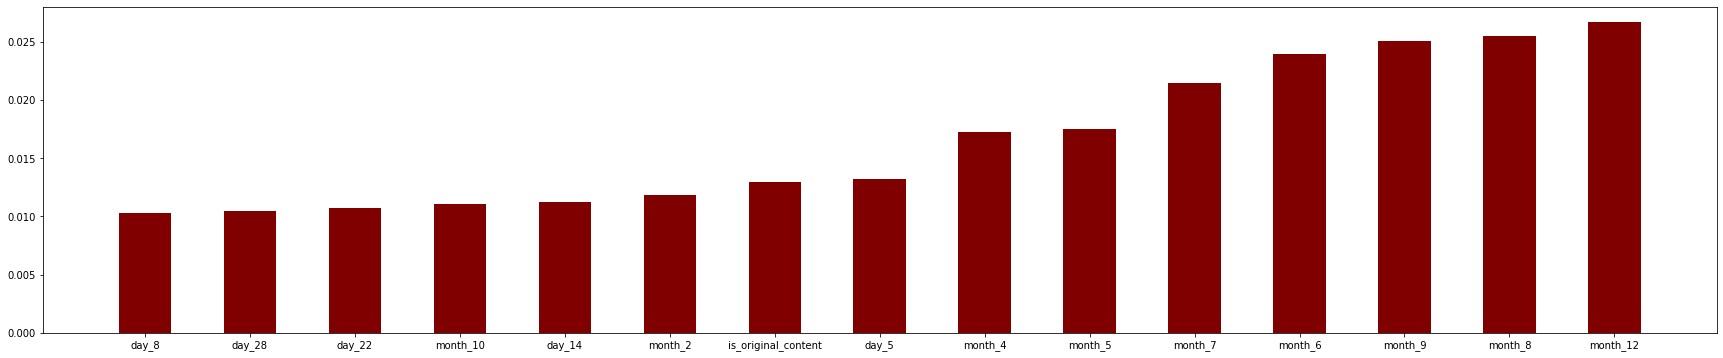

In [ ]:
# top 10 features (in terms of coefficient magnitude)
plt.figure(figsize = (30, 6))
 
# creating the bar plot
plt.bar(coeff_df['features'][-15:],coeff_df['coeff'][-15:], color ='maroon',
        width = 0.5)
        

<BarContainer object of 15 artists>

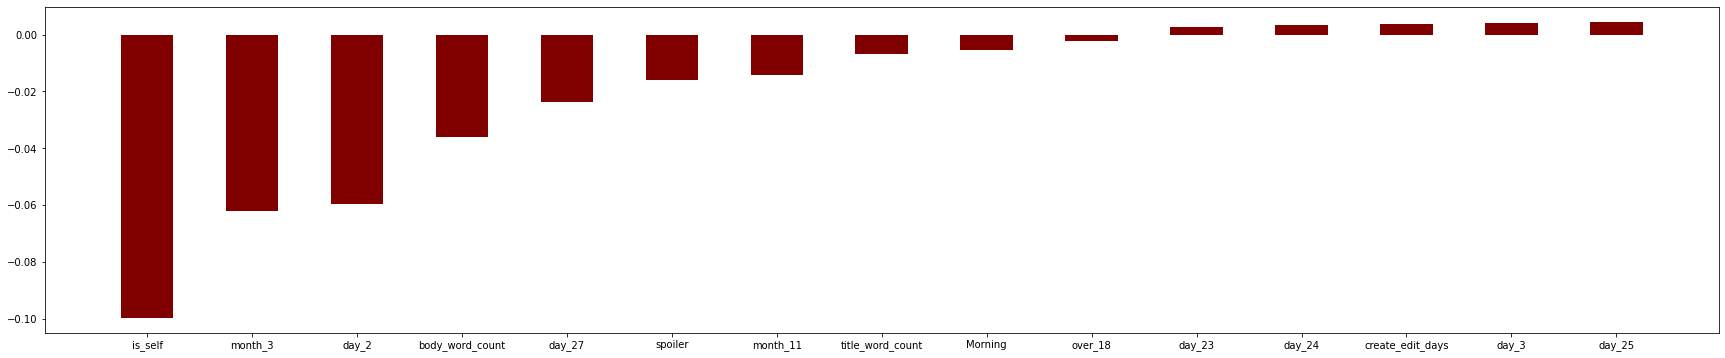

In [ ]:
# lower 10 features (in terms of coefficient magnitude)
plt.figure(figsize = (30, 6))
 
# creating the bar plot
plt.bar(coeff_df['features'][:15],coeff_df['coeff'][:15], color ='maroon',
        width = 0.5)

## Adding subreddit name as a feature (with one hot encoding)

In [ ]:
top_posts["post_type"] = 1
controversial_posts["post_type"] = 0
posts_df_subreddit_info = pd.concat([top_posts, controversial_posts])

In [ ]:
sub_dummies = pd.get_dummies(posts_df_subreddit_info['subreddit'], drop_first=True)
posts_df = pd.concat([posts_df, sub_dummies], axis=1)

In [ ]:
X = posts_df
X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=0.3, random_state=15)

In [ ]:
X_train_bk = X_train.copy()
X_test_bk = X_test.copy()

In [ ]:
del X_train['body']
del X_train['title']
del X_test['body']
del X_test['title']

In [ ]:
scaler = StandardScaler()
Xscaled_fit = scaler.fit(X_train)
Xscaled_train = Xscaled_fit.transform(X_train)
Xscaled_test= Xscaled_fit.transform(X_test)

In [ ]:
# fitting logistic with regularization with subreddit name
clf = LogisticRegressionCV(cv=5, random_state=0).fit(Xscaled_train, y_train)
y_pred = clf.predict(X_test)



              precision    recall  f1-score   support

           0       0.54      0.97      0.70      1213
           1       0.88      0.23      0.36      1278

    accuracy                           0.59      2491
   macro avg       0.71      0.60      0.53      2491
weighted avg       0.71      0.59      0.53      2491





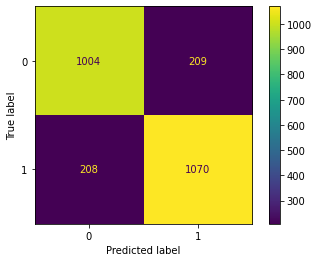

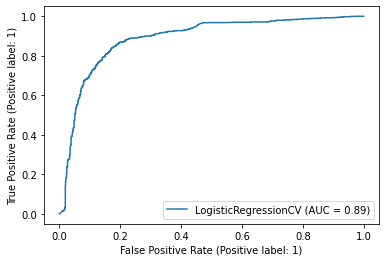

In [ ]:
# getting model accuracy
print(plot_confusion_matrix(clf, Xscaled_test, y_test))
print('\n')
print(classification_report(y_test, y_pred))
plt.plot()
print('\n') 
print(plot_roc_curve(clf, Xscaled_test, y_test))

In [ ]:
coeff_df = pd.DataFrame({'coeff': clf.coef_[0], 'features':X_train.columns.values.tolist()})
coeff_df = coeff_df.sort_values(by='coeff')

<BarContainer object of 15 artists>

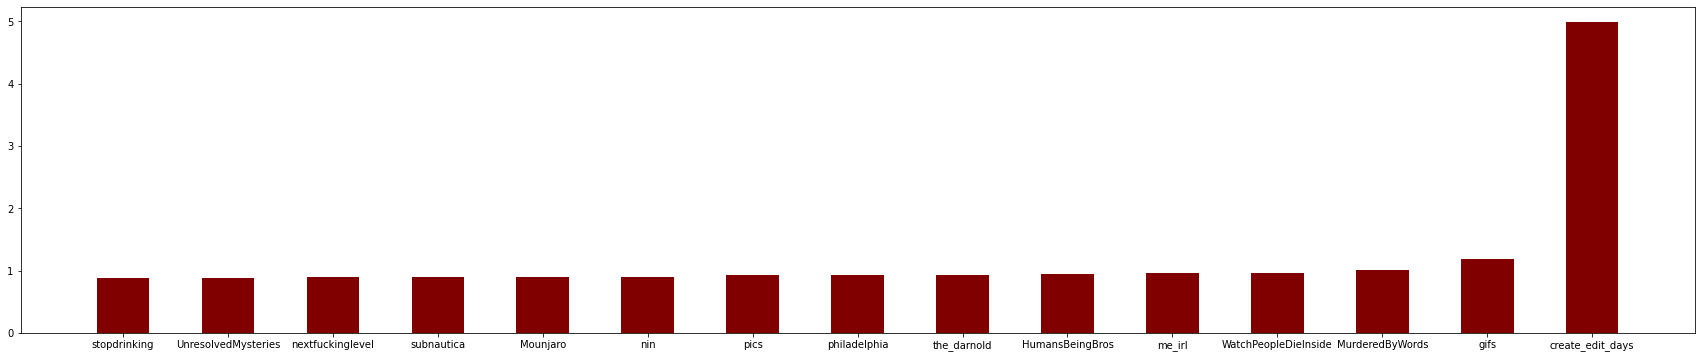

In [ ]:
# plotting top 10 features
plt.figure(figsize = (30, 6))
 
# creating the bar plot
plt.bar(coeff_df['features'][-15:],coeff_df['coeff'][-15:], color ='maroon',
        width = 0.5)

<BarContainer object of 15 artists>

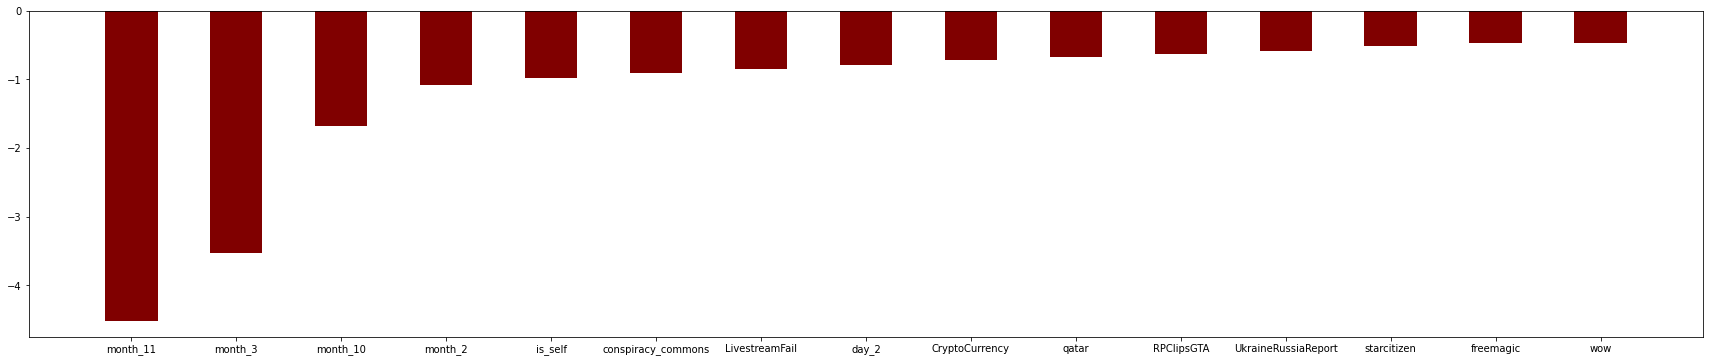

In [ ]:
# plotting bottom 10 features
plt.figure(figsize = (30, 6))
 
# creating the bar plot
plt.bar(coeff_df['features'][:15],coeff_df['coeff'][:15], color ='maroon',
        width = 0.5)

In [ ]:
# only subsetting list of features that dont have a 0 coefficient
features = coeff_df[(coeff_df['coeff'] < -0.1)]['features'].tolist() + coeff_df[(coeff_df['coeff'] > 0.1)]['features'].tolist()

## Feature importance and Random Forest Classifier

In [ ]:
rfc_100 = RandomForestClassifier(random_state=0)

rfc_100.fit(Xscaled_train, y_train)

y_pred_100 = rfc_100.predict(Xscaled_test)

# Check accuracy score 
print('Model accuracy score with default (out of the box) rfm : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with default (out of the box) rfm : 0.8129




              precision    recall  f1-score   support

           0       0.87      0.72      0.79      1213
           1       0.77      0.90      0.83      1278

    accuracy                           0.81      2491
   macro avg       0.82      0.81      0.81      2491
weighted avg       0.82      0.81      0.81      2491





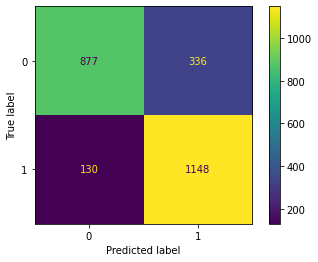

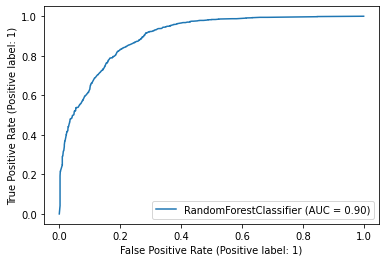

In [ ]:
print(plot_confusion_matrix(rfc_100, Xscaled_test, y_test))
print('\n')
print(classification_report(y_test, y_pred_100))
plt.plot()
print('\n') 
print(plot_roc_curve(rfc_100, Xscaled_test, y_test))

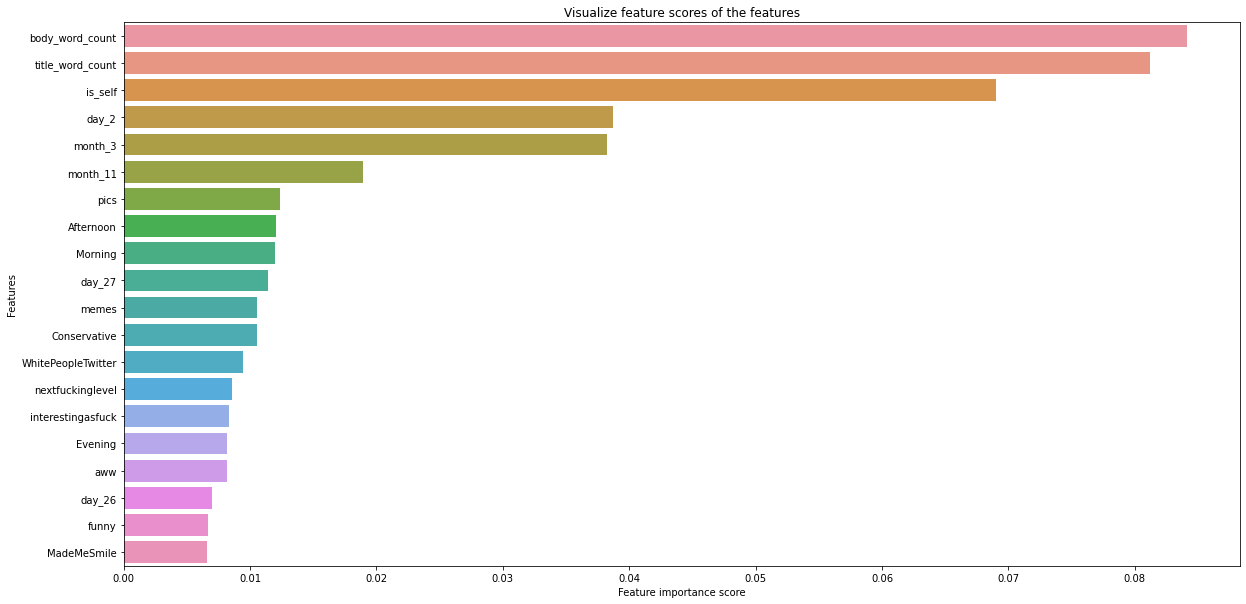

In [ ]:
# Creating a seaborn bar plot (plotting top 20 features)
feature_scores = pd.Series(rfc_100.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x=feature_scores[:20], y=feature_scores.index[:20], data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

RFM feature importance appears to be giving more importance to features having high cardinality. (In this case continuous variables). This might be incorrect so we will use SHAP feature importance instead.

## Default XGBoost Classifier

In [ ]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(Xscaled_train , y_train)

# Predict
preds = xgb_cl.predict(Xscaled_test)



              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1213
           1       0.77      0.88      0.82      1278

    accuracy                           0.80      2491
   macro avg       0.81      0.80      0.80      2491
weighted avg       0.81      0.80      0.80      2491





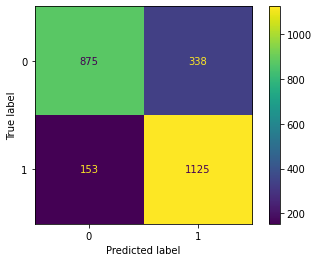

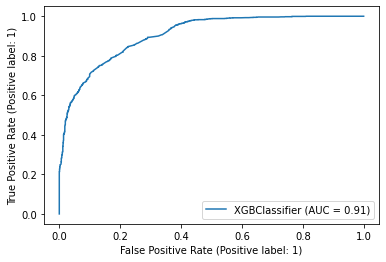

In [ ]:
print(plot_confusion_matrix(xgb_cl, Xscaled_test, y_test))
print('\n')
print(classification_report(y_test, preds))
plt.plot()
print('\n') 
print(plot_roc_curve(xgb_cl, Xscaled_test, y_test))

In [ ]:
xgb_cl.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)>

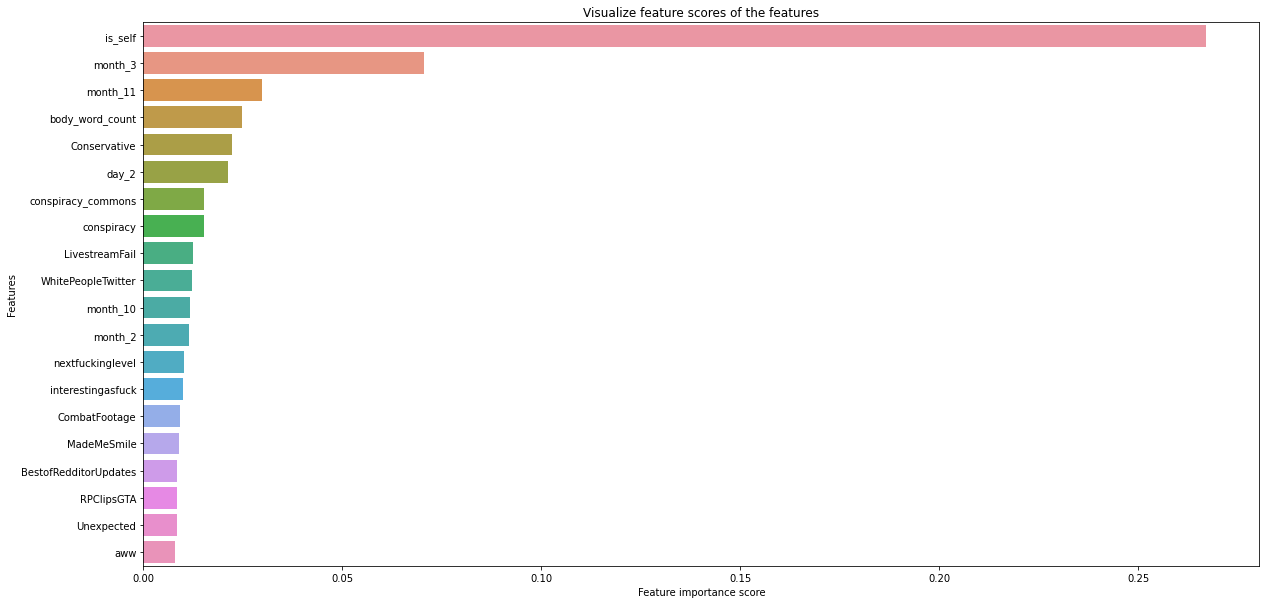

In [ ]:
# Creating a seaborn bar plot
feature_scores = pd.Series(xgb_cl.feature_importances_, index=X_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x=feature_scores[:20], y=feature_scores.index[:20], data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## XGBoost with Bayesian Optimization

In [ ]:
log_file = open('AML_reddit_post_engagement.log', 'a')
AUCbest = -1.
ITERbest = 0

# XGB Cv constructor
def XGB_CV(
          learning_rate,
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree
         ):

    global AUCbest
    global ITERbest


# parameter initialization
    paramt = {
              'booster' : 'gbtree',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'objective' : 'binary:logistic',
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'learning_rate' : learning_rate,
              'scale_pos_weight' :(1-sum(y_train)/len(y_train)),
              }
# folds  
    folds = 5  
    cv_score = 0

    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()

# adding cv
    xgbc = xgb.cv(
                    paramt,
                    dtrain,
                    stratified = True,
                    num_boost_round = 300,
                    nfold = folds,
                    # verbose_eval = 10,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )

# print train and validation sores
    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    print(' Stopped after %d iterations with train-auc = %f val-auc = %f ( diff = %f ) train-gini = %f val-gini = %f' % ( len(xgbc), train_score, val_score, (train_score - val_score), (train_score*2-1),
(val_score*2-1)) )
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score*2) - 1

In [ ]:
#initialize xgb matrix with train setQ
dtrain = xgb.DMatrix(Xscaled_train, label = y_train)

In [ ]:
#parameter search space
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 30),
                                     'gamma': (0.001, 10.0),
                                     'learning_rate':(0.2, 0.8),
                                     'min_child_weight': (1, 10),
                                     'max_delta_step': (1, 10),
                                     'subsample': (0.1, 1.0),
                                     'colsample_bytree' :(0.1, 1.0)
                                    })

In [ ]:
%%time
xgb.set_config(verbosity=0)
print('-'*130)
print('-'*130, file=log_file)
log_file.flush()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=6, n_iter=10, acq='ei', xi=0.0)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
 Stopped after 181 iterations with train-auc = 0.814377 val-auc = 0.809636 ( diff = 0.004742 ) train-gini = 0.628755 val-gini = 0.619271
| 1         | 0.6193    | 0.6657    | 7.949     | 0.3059    | 4.91      | 18.13     | 7.58      | 0.4783    |
 Stopped after 63 iterations with train-auc = 0.812937 val-auc = 0.802253 ( diff = 0.010684 ) train-gini = 0.625875 val-gini = 0.604506
| 2         | 0.6045    | 0.6684    | 1.286     | 0.504     | 4.191     | 12.12     | 7.057     | 0.1808    |
 Stopped after 300 iterations with train-auc = 0.843543 val-auc = 0.836427 ( diff = 0.007117 ) train-gini = 0.687087 val-gini = 0.672853
| 3         | 0.672

In [ ]:
XGB_BO.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)>

In [ ]:
# Init classifier (using best parameters from bayesian optimization)
xgb_cl_tuned = xgb.XGBClassifier(max_depth=10,
                                  gamma=0,
                                  learning_rate=0.3,
                                  min_child_weight=0.5,
                                  max_delta_step=0,
                                  colsample_bytree=0.5,
                                  n_estimators=150)

# Fit
xgb_cl_tuned.fit(Xscaled_train, y_train)

# Predict
preds_tuned = xgb_cl_tuned.predict(Xscaled_test)



              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1213
           1       0.81      0.87      0.84      1278

    accuracy                           0.83      2491
   macro avg       0.83      0.83      0.83      2491
weighted avg       0.83      0.83      0.83      2491





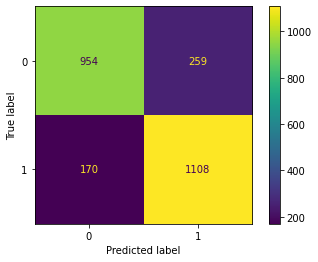

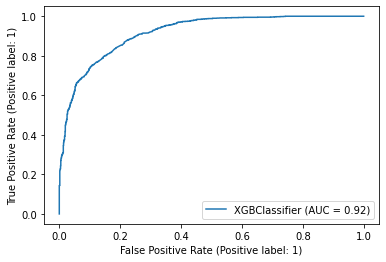

In [ ]:
print(plot_confusion_matrix(xgb_cl_tuned, Xscaled_test, y_test))
print('\n')
print(classification_report(y_test, preds_tuned))
plt.plot()
print('\n') 
print(plot_roc_curve(xgb_cl_tuned, Xscaled_test, y_test))

# Shap feature importance

In [ ]:
# DF, based on which importance is checked
X_importance = X_train

In [ ]:
explainer = shap.TreeExplainer(xgb_cl, Xscaled_train)
shap_values = explainer.shap_values(Xscaled_train)

 94%|=================== | 5447/5810 [00:11<00:00]       

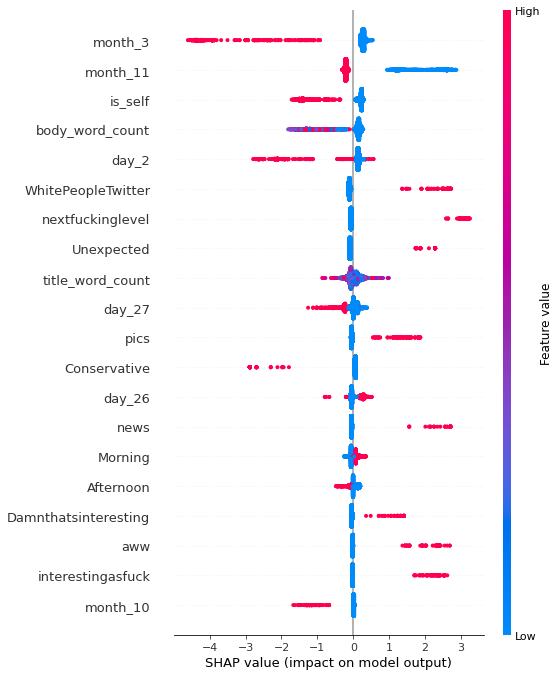

In [ ]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

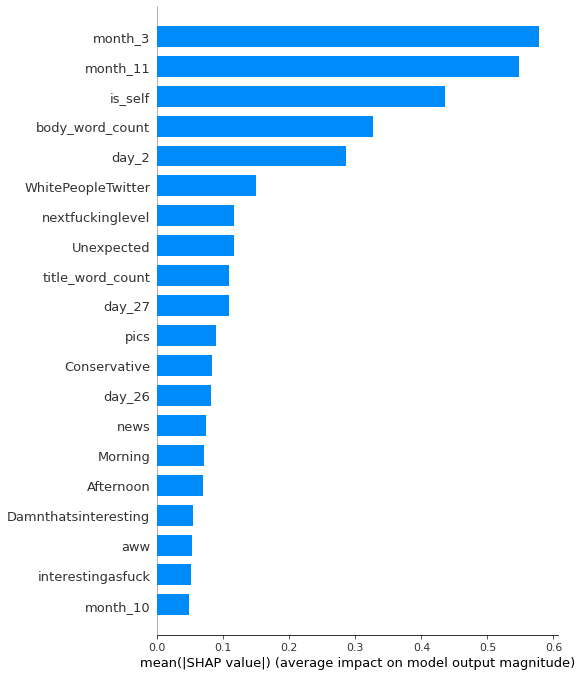

In [ ]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# KeyBERT (keyword extraction)

In [ ]:
concat_bk_train = pd.concat([X_train_bk[['title', 'body']], y_train], axis=1)

In [ ]:
sentence_ls_top = concat_bk_train[concat_bk_train['post_type'] == 1]['title'].tolist()
sentence_ls_contro = concat_bk_train[concat_bk_train['post_type'] == 0]['title'].tolist()

In [ ]:
doc_top = '. '.join(''.join(sent) for sent in sentence_ls_top) + '.'
doc_contro = '. '.join(''.join(sent) for sent in sentence_ls_contro) + '.'
kw_model = KeyBERT()
keywords_top = kw_model.extract_keywords(doc_top)
keywords_contro = kw_model.extract_keywords(doc_contro)

In [ ]:
keywords_top

[('viral', 0.3197),
 ('kitty', 0.3019),
 ('quarantine', 0.2999),
 ('crisis', 0.2994),
 ('cybercrew', 0.2939)]

In [ ]:
keywords_contro

[('antifa', 0.4569),
 ('criminology', 0.3814),
 ('conspiracies', 0.3585),
 ('scapegoating', 0.3309),
 ('scandal', 0.305)]

In [ ]:
kw_model.extract_keywords(doc_top, keyphrase_ngram_range=(2, 2), top_n=10, use_mmr=True, diversity=0.7)

[('internet humongous', 0.4022),
 ('haha lol', 0.2605),
 ('bringing coronavirus', 0.2538),
 ('adorable guardian', 0.201),
 ('cnbc anchor', 0.1708),
 ('cooking stopped', 0.1481),
 ('injustice did', 0.121),
 ('savings lower', 0.114),
 ('endorsing elections', 0.0828),
 ('layer screenprint', -0.0387)]

In [ ]:
kw_model.extract_keywords(doc_contro, keyphrase_ngram_range=(2, 2), top_n=10, use_mmr=True, diversity=0.7)

[('antifa threat', 0.5314),
 ('heard trial', 0.3093),
 ('agree totally', 0.2221),
 ('kidding lololol', 0.1866),
 ('nick fuentes', 0.1636),
 ('miscalculating powder', 0.1273),
 ('outlets ignoring', 0.0895),
 ('rkt cnbc', 0.0829),
 ('dishwasher persistence', 0.0405),
 ('surgery broken', -0.0185)]

In [ ]:
kw_model.extract_keywords(doc_top, keyphrase_ngram_range=(2, 2), stop_words='english',  use_maxsum=True,  top_n=10,  nr_candidates=20)

[('viral friends', 0.3225),
 ('net neutrality', 0.3252),
 ('rescue cat', 0.3264),
 ('unbanning trump', 0.3267),
 ('cyberattacks sway', 0.3382),
 ('quarantine reminder', 0.3393),
 ('turned internet', 0.3414),
 ('neutrality save', 0.3441),
 ('snapchat dad', 0.3456),
 ('blog vitality', 0.3503)]

In [ ]:
kw_model.extract_keywords(doc_contro, keyphrase_ngram_range=(2, 2), stop_words='english',  use_maxsum=True,  top_n=10,  nr_candidates=20)

[('agree criminals', 0.3392),
 ('integrity protestors', 0.3429),
 ('justice 2016', 0.3468),
 ('leftist anti', 0.347),
 ('conspiracies don', 0.3515),
 ('meeting anti', 0.3573),
 ('moscow murders', 0.3828),
 ('investigation dumbest', 0.4129),
 ('criminology podcast', 0.4153),
 ('supporters antifa', 0.4361)]